In [1]:
# ===============================
# 1. Setup
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import levene, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import plotly.express as px

sns.set(style="whitegrid")

# Create folders
os.makedirs("outputs", exist_ok=True)
os.makedirs("csv_files", exist_ok=True)

In [2]:
# ===============================
# 2. Load Data
# ===============================
trader_data = pd.read_csv('/content/drive/MyDrive/ds_Mahathi Jampani/historical_data.csv')
sentiment_data = pd.read_csv('/content/drive/MyDrive/ds_Mahathi Jampani/fear_greed_index.csv')

print("Trader data shape:", trader_data.shape)
print("Sentiment data shape:", sentiment_data.shape)

Trader data shape: (211224, 16)
Sentiment data shape: (2644, 4)


In [3]:
# ===============================
# 3. Data Cleaning
# ===============================
trader_data['time'] = pd.to_datetime(trader_data['Timestamp IST'], format='%d-%m-%Y %H:%M')
sentiment_data['date'] = pd.to_datetime(sentiment_data['date'])

sentiment_data['classification'] = sentiment_data['classification'].str.strip().str.title()
sentiment_mapping = {"Extreme Fear":0,"Fear":1,"Neutral":2,"Greed":3,"Extreme Greed":4}
sentiment_data['sentiment_flag'] = sentiment_data['classification'].map(sentiment_mapping)

trader_data['date'] = pd.to_datetime(trader_data['time'].dt.date)

In [4]:
# ===============================
# 4. Merge Datasets
# ===============================
merged = trader_data.merge(sentiment_data, on="date", how="left")
merged['notional'] = merged['Execution Price'] * merged['Size USD']
merged['win_flag'] = (merged['Closed PnL'] > 0).astype(int)
median_notional = merged['notional'].median()
merged['proxy_leverage'] = merged['notional'] / median_notional

In [5]:
# ===============================
# 5. Exploratory Data Analysis
# ===============================
plot_data = merged.sample(10000, random_state=42)

# 5.1 Avg PnL by Sentiment
avg_pnl = merged.groupby('classification')['Closed PnL'].mean()
sns.barplot(x=avg_pnl.index, y=avg_pnl.values,
            order=["Extreme Fear","Fear","Neutral","Greed","Extreme Greed"])
plt.title("Average PnL by Market Sentiment")
plt.savefig("outputs/avg_pnl_sentiment.png"); plt.close()

In [6]:
# 5.2 PnL Distribution
sns.boxplot(x="classification", y="Closed PnL", data=plot_data,
            order=["Extreme Fear","Fear","Neutral","Greed","Extreme Greed"])
plt.title("PnL Distribution by Sentiment")
plt.savefig("outputs/pnl_distribution.png"); plt.close()

In [7]:
# 5.3 Proxy Leverage Distribution
sns.boxplot(x="classification", y="proxy_leverage", data=plot_data,
            order=["Extreme Fear","Fear","Neutral","Greed","Extreme Greed"])
plt.ylim(0, plot_data['proxy_leverage'].quantile(0.95))
plt.title("Proxy Leverage by Sentiment")
plt.savefig("outputs/proxy_leverage_boxplot.png"); plt.close()

In [8]:
# 5.4 Daily/Weekly Summary
daily = merged.groupby(['date','classification']).agg(
    avg_pnl=('Closed PnL','mean'),
    win_rate=('win_flag','mean'),
    total_volume=('notional','sum'),
    avg_proxy_leverage=('proxy_leverage','mean'),
    sentiment_flag=('sentiment_flag','first')
).reset_index()
daily['week'] = daily['date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly = daily.groupby(['week','classification']).mean().reset_index()

sns.lineplot(data=weekly, x="week", y="win_rate", hue="classification")
plt.title("Weekly Win Rate by Sentiment")
plt.savefig("outputs/weekly_winrate.png"); plt.close()

daily.to_csv("csv_files/daily_summary.csv", index=False)
weekly.to_csv("csv_files/weekly_summary.csv", index=False)

In [9]:
# ===============================
# 6. Hypothesis Testing
# ===============================
groups = [merged.loc[merged['classification']==c, 'Closed PnL'].dropna()
          for c in ["Extreme Fear","Fear","Neutral","Greed","Extreme Greed"]]
print("Levene:", levene(*groups))
print("ANOVA:", f_oneway(*groups))

Levene: LeveneResult(statistic=np.float64(8.659583166669647), pvalue=np.float64(5.518698923909494e-07))
ANOVA: F_onewayResult(statistic=np.float64(9.062225672396693), pvalue=np.float64(2.5753989849026544e-07))


In [10]:
# ===============================
# 7. Summary Metrics & Correlation
# ===============================
sentiment_summary = merged.groupby('classification').agg(
    avg_pnl=('Closed PnL','mean'),
    win_rate=('win_flag','mean'),
    avg_notional=('notional','mean'),
    avg_proxy_leverage=('proxy_leverage','mean')
).reset_index()

sns.heatmap(merged[['Closed PnL','notional','proxy_leverage']].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.savefig("outputs/correlation_heatmap.png"); plt.close()

In [11]:
# ===============================
# 8. Granular Analysis (Coin × Direction)
# ===============================
coin_dir_perf = merged.groupby(['classification','Coin','Direction']).agg(
    avg_pnl=('Closed PnL','mean'),
    win_rate=('win_flag','mean'),
    avg_notional=('notional','mean'),
    avg_proxy_leverage=('proxy_leverage','mean')
).reset_index()

In [12]:
# ===============================
# 9. Statistical Modeling
# ===============================
# Regression (PnL prediction)
X = merged[['Execution Price','Size USD','Start Position','Fee','Size Tokens',
            'proxy_leverage','sentiment_flag','Coin','Side','Direction']]
y = merged['Closed PnL']
cat = ['Coin','Side','Direction']
num = [f for f in X.columns if f not in cat]
pre = ColumnTransformer([('num', SimpleImputer(strategy='median'), num),
                         ('cat', OneHotEncoder(handle_unknown='ignore'), cat)])
reg_model = Pipeline([('pre', pre), ('lr', LinearRegression())])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
reg_model.fit(X_train,y_train)
y_pred=reg_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

MAE: 108.28
MSE: 1562073.07
RMSE: 1249.83
R-squared: -0.0593


In [13]:
# Classification (Win/Loss prediction)
y = merged['win_flag']
clf_model = Pipeline([('pre', pre), ('clf', LogisticRegression(max_iter=1000))])
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
clf_model.fit(X_train,y_train)
y_pred=clf_model.predict(X_test)
print("Classification Accuracy:", accuracy_score(y_test,y_pred))

Classification Accuracy: 0.9170552728133506


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# ===============================
# 10. Time Series (Lagged Sentiment)
# ===============================
daily['lagged_sentiment_1d'] = daily['sentiment_flag'].shift(1)
daily['sentiment_change_1d'] = daily['sentiment_flag'] - daily['lagged_sentiment_1d']
merged_lagged = merged.merge(daily[['date','lagged_sentiment_1d','sentiment_change_1d']],
                             on='date', how='left')

avg_pnl_lagged = merged_lagged.groupby('lagged_sentiment_1d')['Closed PnL'].mean()
win_rate_lagged = merged_lagged.groupby('lagged_sentiment_1d')['win_flag'].mean()


Average PnL by Lagged Sentiment Flag:
lagged_sentiment_1d
0.0    52.185226
1.0    53.528731
2.0    19.305665
3.0    58.720691
4.0    62.019896
Name: Closed PnL, dtype: float64

Win Rate by Lagged Sentiment Flag:
lagged_sentiment_1d
0.0    0.448113
1.0    0.388343
2.0    0.390363
3.0    0.397670
4.0    0.464555
Name: win_flag, dtype: float64


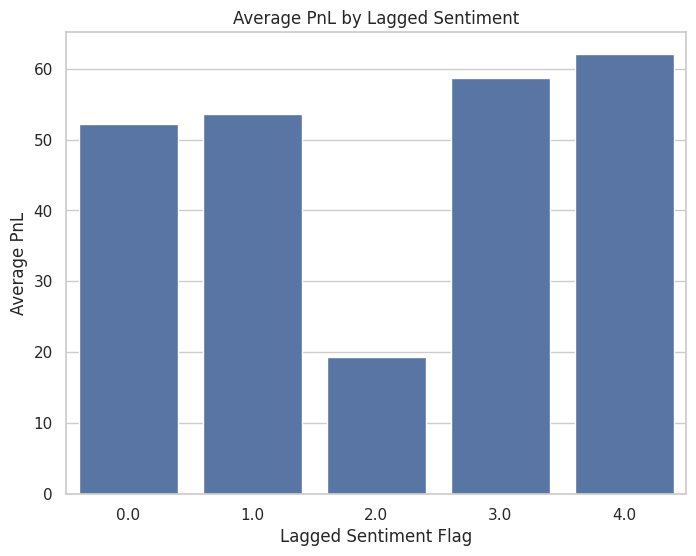

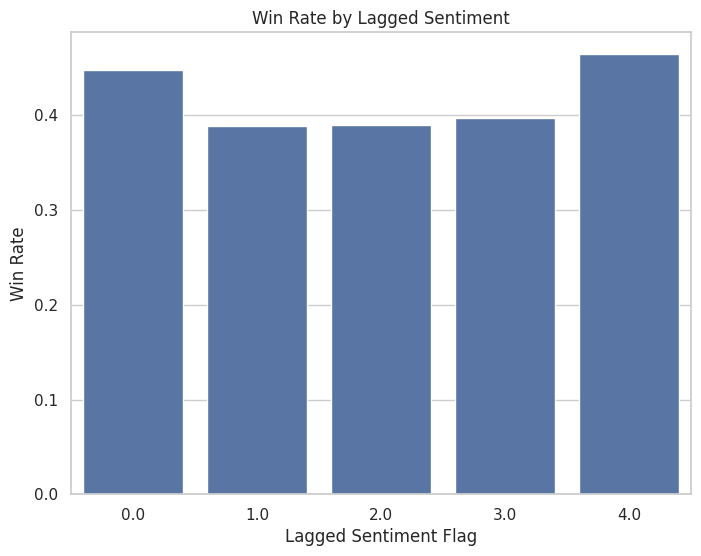

In [15]:
print("\nAverage PnL by Lagged Sentiment Flag:")
print(avg_pnl_lagged)

print("\nWin Rate by Lagged Sentiment Flag:")
print(win_rate_lagged)

# Plotting
plt.figure(figsize=(8,6))
sns.barplot(x=avg_pnl_lagged.index, y=avg_pnl_lagged.values)
plt.title("Average PnL by Lagged Sentiment")
plt.xlabel("Lagged Sentiment Flag")
plt.ylabel("Average PnL")
plt.savefig("outputs/avg_pnl_lagged.png")
plt.show(); plt.close()

plt.figure(figsize=(8,6))
sns.barplot(x=win_rate_lagged.index, y=win_rate_lagged.values)
plt.title("Win Rate by Lagged Sentiment")
plt.xlabel("Lagged Sentiment Flag")
plt.ylabel("Win Rate")
plt.savefig("outputs/winrate_lagged.png")
plt.show(); plt.close()

In [16]:
# ===============================
# 11. Advanced Visuals & Risk
# ===============================
fig = px.scatter(sentiment_summary, x="avg_proxy_leverage", y="avg_pnl",
                 color="classification", title="PnL vs Leverage by Sentiment")
fig.show()

confidence_level=0.95
for s in merged['classification'].unique():
    pnl = merged.loc[merged['classification']==s,'Closed PnL'].dropna()
    if len(pnl)>0:
        var = -np.percentile(pnl, (1-confidence_level)*100)
        cvar = -pnl[pnl<=-var].mean() if len(pnl[pnl<=-var])>0 else 0
        print(s, "VaR:", var, "CVaR:", cvar)

Extreme Greed VaR: 0.220510499999997 CVaR: 135.43924634400003
Extreme Fear VaR: 33.67445874999994 CVaR: 582.0381266383177
Fear VaR: 0.7171149999999874 CVaR: 191.91998826002592
Greed VaR: 13.957307999999996 CVaR: 415.175197463434
Neutral VaR: 5.340448249999992 CVaR: 205.32169591405838


In [17]:
# ===============================
# 12. Save Final Dataset
# ===============================
merged.to_csv("csv_files/cleaned_trader_data.csv", index=False)

In [18]:
import shutil

# Zip the folders
shutil.make_archive("csv_files", 'zip', "csv_files")
shutil.make_archive("outputs", 'zip', "outputs")

'/content/outputs.zip'